The objective of this project is to develop a model capable of accurately classifying butterfly species through the implementation of transfer learning with a Convolutional Neural Network (CNN).

In [ ]:
import os
import shutil

# Standard library for data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split

# necessary libraries
import keras
from sklearn.base import BaseEstimator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from keras.models import Model, Sequential
from keras import layers

import tensorflow as tf

In [30]:
# Read the CSV file into a DataFrame
data = pd.read_csv("Butterfly_dataset/Training_set.csv")

data.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [35]:
os.getcwd()

'C:\\Users\\sandi\\Practice coding\\object-detection'

In [65]:
# Concatenate filename with root directory
data['path'] = 'Butterfly_dataset\\train\\' + data['filename']

data.head()

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,Butterfly_dataset\train\Image_1.jpg
1,Image_2.jpg,ADONIS,Butterfly_dataset\train\Image_2.jpg
2,Image_3.jpg,BROWN SIPROETA,Butterfly_dataset\train\Image_3.jpg
3,Image_4.jpg,MONARCH,Butterfly_dataset\train\Image_4.jpg
4,Image_5.jpg,GREEN CELLED CATTLEHEART,Butterfly_dataset\train\Image_5.jpg


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
 2   path      6499 non-null   object
dtypes: object(3)
memory usage: 152.4+ KB


### Butterfly Classes

In [67]:
butterfly_classes = data['label'].unique()
butterfly_class_num = data['label'].nunique()

print('Classes:')
print(butterfly_classes)

print('-'*80)
print('Number of Classes:')
print(butterfly_class_num)

Classes:
['SOUTHERN DOGFACE' 'ADONIS' 'BROWN SIPROETA' 'MONARCH'
 'GREEN CELLED CATTLEHEART' 'CAIRNS BIRDWING' 'EASTERN DAPPLE WHITE'
 'RED POSTMAN' 'MANGROVE SKIPPER' 'BLACK HAIRSTREAK' 'CABBAGE WHITE'
 'RED ADMIRAL' 'PAINTED LADY' 'PAPER KITE' 'SOOTYWING' 'PINE WHITE'
 'PEACOCK' 'CHECQUERED SKIPPER' 'JULIA' 'COMMON WOOD-NYMPH' 'BLUE MORPHO'
 'CLOUDED SULPHUR' 'STRAITED QUEEN' 'ORANGE OAKLEAF' 'PURPLISH COPPER'
 'ATALA' 'IPHICLUS SISTER' 'DANAID EGGFLY' 'LARGE MARBLE'
 'PIPEVINE SWALLOW' 'BLUE SPOTTED CROW' 'RED CRACKER' 'QUESTION MARK'
 'CRIMSON PATCH' 'BANDED PEACOCK' 'SCARCE SWALLOW' 'COPPER TAIL'
 'GREAT JAY' 'INDRA SWALLOW' 'VICEROY' 'MALACHITE' 'APPOLLO'
 'TWO BARRED FLASHER' 'MOURNING CLOAK' 'TROPICAL LEAFWING' 'POPINJAY'
 'ORANGE TIP' 'GOLD BANDED' 'BECKERS WHITE' 'RED SPOTTED PURPLE'
 'MILBERTS TORTOISESHELL' 'SILVER SPOT SKIPPER' 'AMERICAN SNOOT' 'AN 88'
 'ULYSES' 'COMMON BANDED AWL' 'CRECENT' 'METALMARK' 'SLEEPY ORANGE'
 'PURPLE HAIRSTREAK' 'ELBOWED PIERROT' 'GREAT EGGFLY' 

In [68]:
data.shape

(6499, 3)

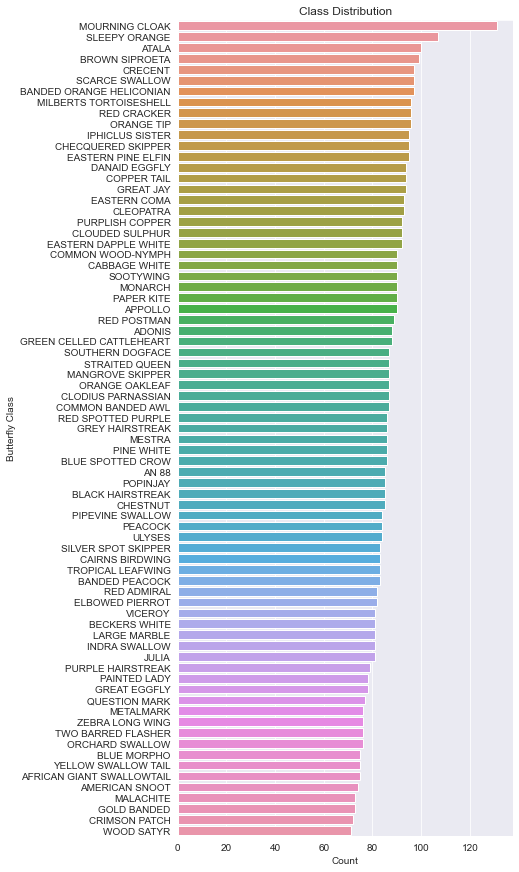

In [70]:
plt.figure(figsize=(6, 15))
sns.countplot(y='label', data=data, order=data['label'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Butterfly Class')
plt.title('Class Distribution')
plt.show()

## Build Model - Transfer Learning

### Train Test Split

In [71]:
# Split data into training and validation sets
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42)

In [72]:
train_data

,filename,label,path
3758,Image_3759.jpg,BLUE MORPHO,Butterfly_dataset\train\Image_3759.jpg
5879,Image_5880.jpg,ULYSES,Butterfly_dataset\train\Image_5880.jpg
4907,Image_4908.jpg,BLUE MORPHO,Butterfly_dataset\train\Image_4908.jpg
5198,Image_5199.jpg,WOOD SATYR,Butterfly_dataset\train\Image_5199.jpg
4733,Image_4734.jpg,EASTERN DAPPLE WHITE,Butterfly_dataset\train\Image_4734.jpg
...,...,...,...
3772,Image_3773.jpg,CLEOPATRA,Butterfly_dataset\train\Image_3773.jpg
5191,Image_5192.jpg,BANDED PEACOCK,Butterfly_dataset\train\Image_5192.jpg
5226,Image_5227.jpg,AMERICAN SNOOT,Butterfly_dataset\train\Image_5227.jpg
5390,Image_5391.jpg,SILVER SPOT SKIPPER,Butterfly_dataset\train\Image_5391.jpg


In [73]:
# check if path is correct


from PIL import Image

img_path = train_data.iloc[0]['path']
Image.open("Butterfly_dataset\\train\\Image_3759.jpg").show()


In [141]:
# use this function for preparing data  

def prep_data(train_data, validation_data, batch_size=16):
    # Create ImageDataGenerator for training set
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_set = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse')

    # Create ImageDataGenerator for validation set
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    validation_set = validation_datagen.flow_from_dataframe(
        dataframe=validation_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse')

    return train_set, validation_set

In [142]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [143]:
train_set, validation_set = prep_data(train_data, validation_data)

# Accessing the data
images, labels = next(train_set)

# Retrieving class names
class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()} 

Found 4549 validated image filenames belonging to 75 classes.
Found 1950 validated image filenames belonging to 75 classes.


In [144]:
train_set

In [145]:
images[0]

array([[[0.18039216, 0.18431373, 0.12941177],
        [0.18431373, 0.18823531, 0.13333334],
        [0.19607845, 0.20000002, 0.13725491],
        ...,
        [0.19607845, 0.16862746, 0.10588236],
        [0.19607845, 0.17254902, 0.10980393],
        [0.18039216, 0.16862746, 0.10196079]],

       [[0.18431373, 0.18823531, 0.13333334],
        [0.18431373, 0.18823531, 0.13333334],
        [0.19607845, 0.20000002, 0.13725491],
        ...,
        [0.18823531, 0.16078432, 0.09803922],
        [0.18039216, 0.16862746, 0.10196079],
        [0.18431373, 0.17254902, 0.10588236]],

       [[0.19607845, 0.20000002, 0.14509805],
        [0.18823531, 0.19215688, 0.13725491],
        [0.20392159, 0.20784315, 0.15294118],
        ...,
        [0.19607845, 0.17254902, 0.10980393],
        [0.20392159, 0.19215688, 0.11764707],
        [0.22352943, 0.21176472, 0.13725491]],

       ...,

       [[0.13333334, 0.13333334, 0.08627451],
        [0.13333334, 0.13333334, 0.08627451],
        [0.14509805, 0

In [146]:
labels[0]

33.0

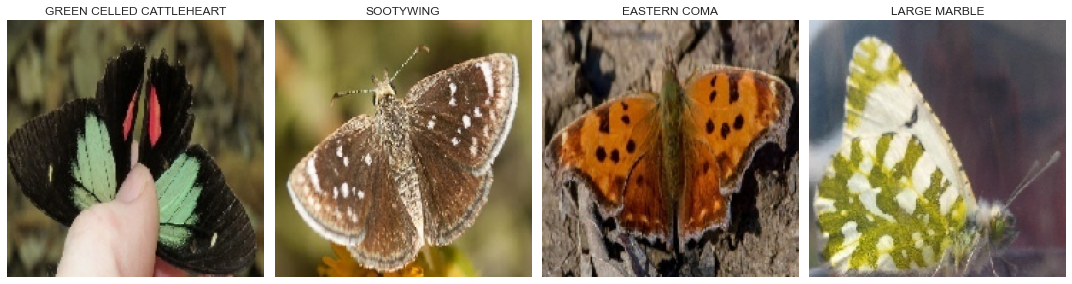

In [147]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Transfer Learning

In [148]:
# importing pretrained models 
from tensorflow.keras.applications import InceptionV3

In [149]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [150]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 89, 89, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 89, 89, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 89, 89, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [151]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [154]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(butterfly_class_num, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam", 
    metrics=['accuracy']
)

model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [155]:
modelv1 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,
    )

Epoch 1/40
     94/Unknown - 7s 34ms/step - loss: 5.3672 - accuracy: 0.0436

KeyboardInterrupt: 

In [163]:
len(train_data)

4549